In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.table import Table
import lightkurve as lk
from scipy.optimize import curve_fit
from astropy.timeseries import LombScargle

from stuff import Barnes2003_C, Barnes2003_I, BarnesPdot, OmC, bv2teff, gaus, twogaus

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})


In [3]:
santos21 = '../data/apjsac033ft1_mrt.txt'
tbl21 = Table.read(santos21, format='ascii')

santos19 = '../data/apjsab3b56t3_mrt.txt'
tbl19 = Table.read(santos19, format='ascii')

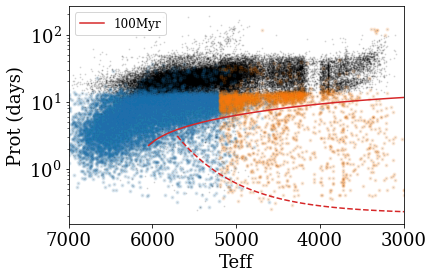

In [4]:
P21 = (tbl21['E_Prot'] < 1) & (tbl21['flag3'] == 0)
P19 = (tbl19['E_Prot'] < 1) & (tbl19['flag3'] != 1)

plt.scatter(tbl21['Teff'], tbl21['Prot'], s=1, c='k', alpha=0.1)
plt.scatter(tbl19['Teff'], tbl19['Prot'], s=1, c='k', alpha=0.1)

plt.scatter(tbl21['Teff'][P21], tbl21['Prot'][P21], s=10, alpha=0.1)
plt.scatter(tbl19['Teff'][P19], tbl19['Prot'][P19], s=10, alpha=0.1)

plt.yscale('log')
plt.xlim(7000,3000)
plt.xlabel('Teff')
plt.ylabel('Prot (days)')

BV = np.linspace(0.55,2.5,100)
plt.plot(bv2teff(BV), Barnes2003_I(BV, 100), label='100Myr', c='C3')
plt.plot(bv2teff(BV), Barnes2003_C(BV, 100),ls='--', c='C3')
plt.legend(fontsize=12)

(758,)  Kepler targets


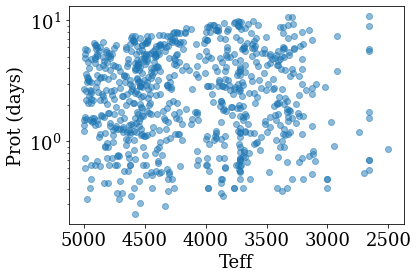

In [5]:
# define the upper-limit of P_rot, based on 100Myr Barnes(2003) gyrochrone
ulim = np.interp(tbl19['Teff'], bv2teff(BV)[::-1], Barnes2003_I(BV, 100)[::-1])

# we want cool stars (Teff<5000K), with short periods (i.e. within the "gap")
targets = np.where((tbl19['Prot'] <= ulim) & (tbl19['Teff'] < 5000))[0]

# look at them
plt.scatter(tbl19['Teff'][targets], tbl19['Prot'][targets], alpha=0.5)
plt.gca().invert_xaxis()
plt.xlabel('Teff')
plt.ylabel('Prot (days)')
plt.yscale('log')

print(targets.shape, ' Kepler targets')

In [6]:
# make a contour visualization of the Pdot expected across the color-period space

pdot_grid = np.zeros((200,100))
bv_grid = np.linspace(0.45, 2.5, 200)
prot_grid = np.logspace(-1, 1.5, 100)
time = np.linspace(30,2999,100)

for k in range(len(bv_grid)):
    Pk = Barnes2003_C(bv_grid[k],time)
    Pdotk = BarnesPdot(bv_grid[k], time)
    ok = np.isfinite(Pk)
    pdot_grid[k,:] = np.log10(np.interp(prot_grid, Pk[ok], Pdotk[ok]))
pdot_grid[np.isinf(pdot_grid)] = np.nan

/Users/james/Dropbox/research_projects/rapid-spin-down/code/stuff.py:11: RuntimeWarning: invalid value encountered in sqrt
  P = np.sqrt(t) * np.sqrt(BV - 0.5) - 0.15 * (BV - 0.5)
/Users/james/Dropbox/research_projects/rapid-spin-down/code/stuff.py:23: RuntimeWarning: overflow encountered in exp
  P = 0.2 * np.exp(t / (100* (BV + 0.1 - (t/3000))**3))
/Users/james/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1069: RuntimeWarning: invalid value encountered in subtract
  out[tuple(slice1)] = (f[tuple(slice4)] - f[tuple(slice2)]) / (2. * ax_dx)
<ipython-input-6-463a51b6a6b2>:12: RuntimeWarning: divide by zero encountered in log10
  pdot_grid[k,:] = np.log10(np.interp(prot_grid, Pk[ok], Pdotk[ok]))


Text(0, 0.5, 'Prot (days)')

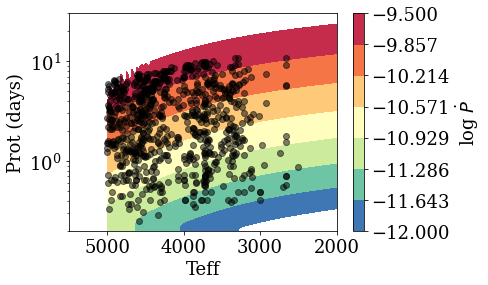

In [7]:
plt.contourf(bv2teff(bv_grid), prot_grid, pdot_grid.T, levels=np.linspace(-12,-9.5,8), 
             cmap=plt.cm.Spectral_r)

plt.gca().invert_xaxis()
cb = plt.colorbar()
cb.set_label('log $\dot{P}$')

plt.scatter(tbl19['Teff'][targets], tbl19['Prot'][targets], alpha=0.5, c='k')

plt.xlim(5500,2000)
plt.yscale('log')
plt.ylim(0.2,30)
plt.xlabel('Teff')
plt.ylabel('Prot (days)')

# try pulling real data

  KIC    Prot Teff  Q  
          d    K       
-------- ---- ---- ----
 3765091 5.12 4498 1-17
 3859512 5.27 4415 1-17
 3935803 1.67 4445 1-17
 3962715 0.53 4441 1-17
 4169930 0.41 4438 1-17
 4249808  2.0 4464 1-17
 4274517  7.5 4447 1-17
 5018976 1.79 4484 1-17
 5115335 0.77 4495 1-17
 5894155 3.55 4440 1-17
     ...  ...  ...  ...
 9018449 4.02 4422 1-17
 9820789 4.55 4426 1-17
10317398 1.71 4465 1-17
10553852 4.05 4449 1-17
10776918  5.3 4492 1-17
11658934 3.75 4445 1-17
12009347 5.84 4416 1-17
12071053  2.8 4447 1-17
12599998 2.44 4453 1-17
12601939 0.87 4403 1-17
Length = 33 rows
33


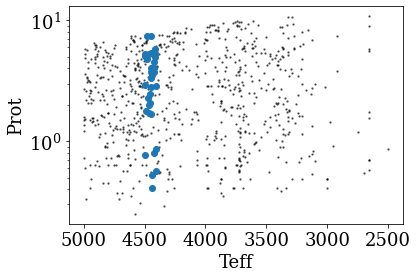

In [103]:
tt = ((tbl19['Teff'][targets] < 4500) & (tbl19['Teff'][targets] > 4400) & 
      (tbl19['Q'][targets]=='1-17') & 
      (tbl19['Prot'][targets] > .2) & (tbl19['Prot'][targets] <= 15))
plt.scatter(tbl19['Teff'][targets], tbl19['Prot'][targets], alpha=0.5, c='k', s=2)
plt.scatter(tbl19['Teff'][targets][tt], tbl19['Prot'][targets][tt])
plt.xlabel('Teff')
plt.gca().invert_xaxis()
plt.ylabel('Prot')

print(tbl19['KIC', 'Prot', 'Teff', 'Q'][targets][tt])
plt.yscale('log')
print(sum(tt))

In [104]:
nper = 5 # how many periods to fit at a time
pts_lim = 50

for j in range(5,sum(tt)):
    obj = 'KIC ' + str(tbl19['KIC'][targets][tt][j])
    print(j, obj)
    
    #### PULL THE DATA
    lc_list = lk.search_lightcurve(obj, mission='Kepler', cadence='long')
    lc_l = lc_list.download_all()
    lc = lc_l[0].normalize()
    for k in range(2,len(lc_l)):
        lc = lc.append(lc_l[k].normalize())

    # no TESS data, unfortunately
    print(lk.search_lightcurve(obj, mission='TESS'))

    lc.plot()
    plt.savefig('../figures/'+obj+'_lc.png',bbox_inches='tight')
    plt.close()
    
    ###### FOLD THE LC
    lok = np.where(np.isfinite(lc.flux.value) & (lc.flux.value < 1.05))[0]

    frequency, power = LombScargle(lc.time.value[lok], lc.flux.value[lok]).autopower(maximum_frequency=1./0.1)
    per = 1./frequency[np.argmax(power)]
    print(per)

    firstP = np.where((lc.time.value[lok] <= (np.nanmin(lc.time.value[lok])+per)))[0]
    approx_t0 = lc.time.value[lok][firstP][np.argmin(lc.flux.value[lok][firstP])]

    EPHEM = approx_t0
    phase = ((lc.time.value - EPHEM) % per) / per # define for help later

    # the total span of the data, in period units... though there's a HUGE gap
    nfold = (np.nanmax(lc.time.value) - np.nanmin(lc.time.value)) / per

    # i want the center times of all eclipses that happen between Start/Stop times
    t0_list = np.arange(int(nfold)) * per + approx_t0 #(EPHEM*per) - phase[0] + lc.time.value[0] + per

    plt.figure()
    plt.plot(lc.time.value[lok], lc.flux.value[lok])
    plt.scatter(t0_list, np.ones_like(t0_list), c='C1')
    plt.xlim(t0_list[0]-per, t0_list[0]+per*8)
    plt.ylim(.95,1.05)
    plt.title(obj+', Teff='+str(tbl19['Teff'][targets][tt][j]), fontsize=14)
    plt.savefig('../figures/'+obj+'_lc_tight.png',bbox_inches='tight', dpi=150)
    plt.close()
    
    ##### O - C calc
    OminusC = np.zeros(int(nfold)) - 99
    OminusC_err = np.zeros(int(nfold)) - 99

    OminusC2 = np.zeros(int(nfold)) - 99
    OminusC_err2 = np.zeros(int(nfold)) - 99

    for k in range(int(nfold)):
        kpts = np.where((lc.time.value[lok] >= t0_list[k] - per*nper/2) & 
                        (lc.time.value[lok] <= t0_list[k] + per*nper/2))[0]
        if len(kpts) >= pts_lim:
            p0 = [-0.03, -0.1, 0.075, -0.02, 0.2, 0.04, 
                  np.nanmax(lc.flux.value[lok[kpts]])]

            bounds = ((-0.1, -1, 0, -0.1, -1, 0, 0), 
                      (0, 1, 0.5, 0, 1, 0.5, 0.5))
            try:
                popt, pcov = curve_fit(twogaus, phase[lok][kpts], lc.flux.value[lok][kpts],
                                   p0=p0, maxfev=19999, sigma=lc.flux_err.value[lok][kpts])
                errs = np.sqrt(np.diag(pcov))

                OminusC[k] = (popt[1]*per + t0_list[k]) - t0_list[k]
                OminusC_err[k] = errs[1]*per
                OminusC2[k] = (popt[4]*per + t0_list[k]) - t0_list[k]
                OminusC_err2[k] = errs[4]*per

            except RuntimeError:
                OminusC[k] = -999


    Ook = np.where((OminusC > -99) & (OminusC_err > -99) & (OminusC_err < .1))[0]
    plt.figure()
    plt.errorbar(t0_list[Ook], (OminusC[Ook])*24*60, yerr=OminusC_err[Ook]*24*60, 
                 linestyle='none', marker='o', alpha=0.5)
    plt.errorbar(t0_list[Ook], (OminusC2[Ook])*24*60, yerr=OminusC_err2[Ook]*24*60, 
                 linestyle='none', marker='o', alpha=0.5)
    
    plt.scatter(t0_list[Ook], (OminusC[Ook])*24*60 - per*24*60,marker='.', alpha=0.1, c='C0')
    plt.scatter(t0_list[Ook], (OminusC2[Ook])*24*60 - per*24*60, marker='.', alpha=0.1, c='C1')
    plt.scatter(t0_list[Ook], (OminusC[Ook])*24*60 + per*24*60,marker='.', alpha=0.1, c='C0')
    plt.scatter(t0_list[Ook], (OminusC2[Ook])*24*60 + per*24*60, marker='.', alpha=0.1, c='C1')
    plt.plot([t0_list[Ook][0], t0_list[Ook][-1]], [-1*per*24*60/2,-1*per*24*60/2], c='grey' )
    plt.plot([t0_list[Ook][0], t0_list[Ook][-1]], [per*24*60/2,per*24*60/2], c='grey' )

    plt.ylabel('O-C (min)')
    plt.xlabel('Time (days)')
    plt.ylim(-1*per*24*60, per*24*60)
    plt.title(obj)
    plt.savefig('../figures/'+obj+'_OmC.png',bbox_inches='tight', dpi=150)
    plt.close()
    
    plt.figure()
    _ = plt.hist(OminusC_err[Ook]*24*60,bins=np.linspace(0, 3*np.nanmedian(OminusC_err[Ook]*24*60),100))
    plt.title(obj)
    plt.xlabel('O-C Error (min)')
    plt.savefig('../figures/'+obj+'_OmCerr.png',bbox_inches='tight', dpi=150)
    plt.close()

5 KIC 4249808


No data found for target "KIC 4249808".


SearchResult containing 0 data products.
2.0256612500441764


/Users/james/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-104-3eab06a29a79>:69: RuntimeWarning: invalid value encountered in sqrt
  errs = np.sqrt(np.diag(pcov))


6 KIC 4274517


No data found for target "KIC 4274517".


SearchResult containing 0 data products.
7.759111435483046


/Users/james/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


7 KIC 5018976


No data found for target "KIC 5018976".


SearchResult containing 0 data products.
1.8101065315887568


/Users/james/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-104-3eab06a29a79>:69: RuntimeWarning: invalid value encountered in sqrt
  errs = np.sqrt(np.diag(pcov))


8 KIC 5115335
SearchResult containing 2 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 14 2019    QLP    1800   184247277      0.0
  1 TESS Sector 15 2019    QLP    1800   184247277      0.0
0.7832817489834106


<ipython-input-104-3eab06a29a79>:69: RuntimeWarning: invalid value encountered in sqrt
  errs = np.sqrt(np.diag(pcov))
/Users/james/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


9 KIC 5894155


No data found for target "KIC 5894155".


SearchResult containing 0 data products.
3.5868491321734237


/Users/james/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-104-3eab06a29a79>:69: RuntimeWarning: invalid value encountered in sqrt
  errs = np.sqrt(np.diag(pcov))


10 KIC 6141300


No data found for target "KIC 6141300".


SearchResult containing 0 data products.
5.359856496353167


<ipython-input-104-3eab06a29a79>:69: RuntimeWarning: invalid value encountered in sqrt
  errs = np.sqrt(np.diag(pcov))


11 KIC 6675318


No data found for target "KIC 6675318".


SearchResult containing 0 data products.
0.5780841481081874


<ipython-input-104-3eab06a29a79>:69: RuntimeWarning: invalid value encountered in sqrt
  errs = np.sqrt(np.diag(pcov))
/Users/james/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


12 KIC 7036755
SearchResult containing 1 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 15 2019    QLP    1800    63371894      0.0
3.793836742388648


/Users/james/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


13 KIC 7293120


No data found for target "KIC 7293120".


SearchResult containing 0 data products.
5.094202410483733


<ipython-input-104-3eab06a29a79>:69: RuntimeWarning: invalid value encountered in sqrt
  errs = np.sqrt(np.diag(pcov))


14 KIC 7347797


No data found for target "KIC 7347797".


SearchResult containing 0 data products.
5.447887552300075


<ipython-input-104-3eab06a29a79>:69: RuntimeWarning: invalid value encountered in sqrt
  errs = np.sqrt(np.diag(pcov))


15 KIC 8006143


No data found for target "KIC 8006143".


SearchResult containing 0 data products.
2.945487750481692


<ipython-input-104-3eab06a29a79>:69: RuntimeWarning: invalid value encountered in sqrt
  errs = np.sqrt(np.diag(pcov))
/Users/james/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


16 KIC 8288698
SearchResult containing 1 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 14 2019    QLP    1800   158484576      0.0
7.605466996528087
17 KIC 8314902


No data found for target "KIC 8314902".


SearchResult containing 0 data products.
0.8145035375175004


/Users/james/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-104-3eab06a29a79>:69: RuntimeWarning: invalid value encountered in sqrt
  errs = np.sqrt(np.diag(pcov))


18 KIC 8365196


No data found for target "KIC 8365196".


SearchResult containing 0 data products.
4.902549803313646


/Users/james/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


19 KIC 8482565


No data found for target "KIC 8482565".


SearchResult containing 0 data products.
2.9646336408884117


/Users/james/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


20 KIC 8604575


No data found for target "KIC 8604575".


SearchResult containing 0 data products.
2.275119564642918


/Users/james/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-104-3eab06a29a79>:69: RuntimeWarning: invalid value encountered in sqrt
  errs = np.sqrt(np.diag(pcov))


21 KIC 8873450
SearchResult containing 1 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 14 2019    QLP    1800   158320130      0.0
3.3870716108933214


/Users/james/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-104-3eab06a29a79>:69: RuntimeWarning: invalid value encountered in sqrt
  errs = np.sqrt(np.diag(pcov))


22 KIC 9011963


No data found for target "KIC 9011963".


SearchResult containing 0 data products.
2.0948602701916514


/Users/james/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-104-3eab06a29a79>:69: RuntimeWarning: invalid value encountered in sqrt
  errs = np.sqrt(np.diag(pcov))


23 KIC 9018449


No data found for target "KIC 9018449".


SearchResult containing 0 data products.
4.080204432457222


/Users/james/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-104-3eab06a29a79>:69: RuntimeWarning: invalid value encountered in sqrt
  errs = np.sqrt(np.diag(pcov))


24 KIC 9820789


No data found for target "KIC 9820789".


SearchResult containing 0 data products.
4.6113403362598255


/Users/james/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-104-3eab06a29a79>:69: RuntimeWarning: invalid value encountered in sqrt
  errs = np.sqrt(np.diag(pcov))


25 KIC 10317398


No data found for target "KIC 10317398".


SearchResult containing 0 data products.
1.7405954992310582


/Users/james/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-104-3eab06a29a79>:69: RuntimeWarning: invalid value encountered in sqrt
  errs = np.sqrt(np.diag(pcov))


26 KIC 10553852


No data found for target "KIC 10553852".


SearchResult containing 0 data products.
4.114714298756064


/Users/james/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-104-3eab06a29a79>:69: RuntimeWarning: invalid value encountered in sqrt
  errs = np.sqrt(np.diag(pcov))


27 KIC 10776918


No data found for target "KIC 10776918".


SearchResult containing 0 data products.
5.344157202323221


/Users/james/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


28 KIC 11658934


No data found for target "KIC 11658934".


SearchResult containing 0 data products.
3.8621045223931465


<ipython-input-104-3eab06a29a79>:69: RuntimeWarning: invalid value encountered in sqrt
  errs = np.sqrt(np.diag(pcov))
/Users/james/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


29 KIC 12009347


No data found for target "KIC 12009347".


SearchResult containing 0 data products.
5.896926611870253


/Users/james/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


30 KIC 12071053


No data found for target "KIC 12071053".


SearchResult containing 0 data products.
2.845443524213317


<ipython-input-104-3eab06a29a79>:69: RuntimeWarning: invalid value encountered in sqrt
  errs = np.sqrt(np.diag(pcov))
/Users/james/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


31 KIC 12599998


No data found for target "KIC 12599998".


SearchResult containing 0 data products.
2.4859298024702254


/Users/james/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-104-3eab06a29a79>:69: RuntimeWarning: invalid value encountered in sqrt
  errs = np.sqrt(np.diag(pcov))


32 KIC 12601939


No data found for target "KIC 12601939".


SearchResult containing 0 data products.
0.8874973399966246


/Users/james/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-104-3eab06a29a79>:69: RuntimeWarning: invalid value encountered in sqrt
  errs = np.sqrt(np.diag(pcov))


In [105]:
'done'

'done'